# TP2 - Linear Regression
___

In [1]:
df = pd.read_csv('data_tp_2.csv')
Y = df.Y
df = df.drop('Y', axis=1)
X = df.values
n, p = X.shape
print(n, p)

plt.plot(X.mean(axis=0))
plt.plot(X.std(axis=0))
plt.yscale('log')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
df_test = pd.DataFrame()
df_coef = pd.DataFrame()
results = []

X_train = StandardScaler().fit_transform(X_train)
plt.plot(X_train.mean(axis=0))
plt.plot(X_train.std(axis=0))

X_test = StandardScaler().fit_transform(X_test)
plt.plot(X_test.mean(axis=0))
plt.plot(X_test.std(axis=0))

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
print('\nDetermination coefficient R^2 = {:.4f}.\n'.format(
    lin_reg.score(X_train, y_train)))
y_pred = lin_reg.predict(X_train)
print(det_coef(y_train, y_pred))
print(MSE(y_train, y_pred))
1-np.sum(np.power(y_train - y_pred, 2)) / \
    np.sum(np.power(y_train - y_train.mean(), 2))

NameError: name 'pd' is not defined

##### File naming

In [2]:
fn1 = "bourhan"
ln1 = "dernayka"
filename = "_".join(map(lambda s: s.strip().lower(), [
                    "SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
print(filename)

sd-tsia204_lab2_dernayka_bourhan.ipynb


___
### 1- Process the data

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

from scipy.stats import norm, t

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style="whitegrid")

In [4]:
data = pd.read_csv("data_tp_2.csv", usecols=all)
data.head()

,X76,X95,X52,X36,X74,X69,X23,X27,X19,X39,...,X45,X67,X16,X37,X56,X35,X87,X89,X96,Y
0,-0.208298,0.793446,-0.200865,-0.005766,-0.336092,0.037238,0.148319,-1.423624,-0.411594,0.541975,...,-0.216825,0.552672,0.499400,0.134669,-1.639742,-0.004640,-0.635006,-0.758949,0.488324,24.0
1,-0.221028,-0.363311,-0.631604,1.152664,-0.532182,1.176513,-0.100142,1.170051,0.360931,0.593115,...,0.571930,-0.186832,-0.238081,1.404931,0.489104,0.248675,0.361039,0.435418,-1.324025,21.6
2,-1.059124,-0.777557,-0.172609,0.767116,0.141027,0.677921,0.820292,-0.255193,0.691621,0.254366,...,-0.643929,-0.543850,-0.478493,-0.386637,0.175114,-0.658092,-0.338583,-0.177981,-0.050339,34.7
3,1.133450,-0.790638,-0.586627,0.942378,0.283674,-0.577118,-0.145977,-0.263209,1.435926,-0.750034,...,0.719154,0.056236,-0.495367,0.204324,-1.078683,0.640999,-0.921276,-0.602238,0.421393,33.4
4,0.908181,-0.913293,0.362265,-0.437131,0.514517,-1.625222,1.019997,-0.422887,0.140903,-0.073760,...,1.026587,-0.230706,0.151710,-0.638937,0.072631,-0.517829,-1.028707,0.465484,0.351005,36.2


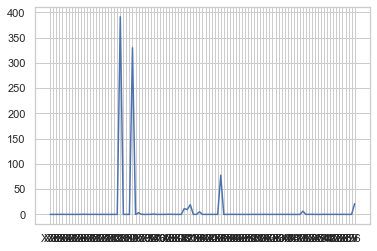

In [5]:
plot = plt.plot(data.median())

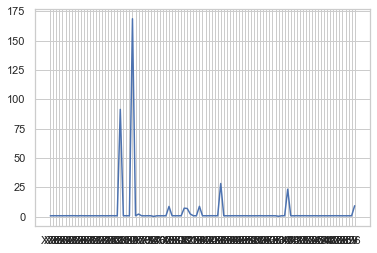

In [6]:
plot = plt.plot(data.std())

In [7]:
sum(data.median() < 1), sum(data.std() < 1)

(91, 90)

    We note that most of the data is close to being centered, 91 covariates out of 100 have a mean lesser than 1.
    Also, 90 covariates have standard deviations of less than 1.
    Hence, The data is not centered, normalized nor standardized (centered + normalized).

In [8]:
X = data.iloc[:, :-1]
X_matrix = X.to_numpy()
y = data.iloc[:, -1]
y_matrix = y.to_numpy()
n, p = X_matrix.shape

    We split the data into train and test sets, one fourth of the data is for testing.
    
    Note: removing the random_state parameter will generate different data partition on each run. However I opted to keep the same data partition throughout this study.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

    We standarize our data using the StandardScaler() method fit_transform

In [10]:
X_train_matrix_fitted = StandardScaler().fit_transform(X_train)
X_test_matrix_fitted = StandardScaler().fit_transform(X_test)

    In fact this is equivalent to doing it by hand: (small error difference comparing to the fit_transform method)

In [11]:
X_train_fitted = (X_train - np.mean(X_train))/np.std(X_train)
X_test_fitted = (X_test - np.mean(X_test)) / np.std(X_test)

In [12]:
print("total difference is", sum(
    sum(np.array(X_train_fitted-X_train_matrix_fitted))))

total difference is 7.0992893977232276e-12


We can see that this is indeed a negligible error.

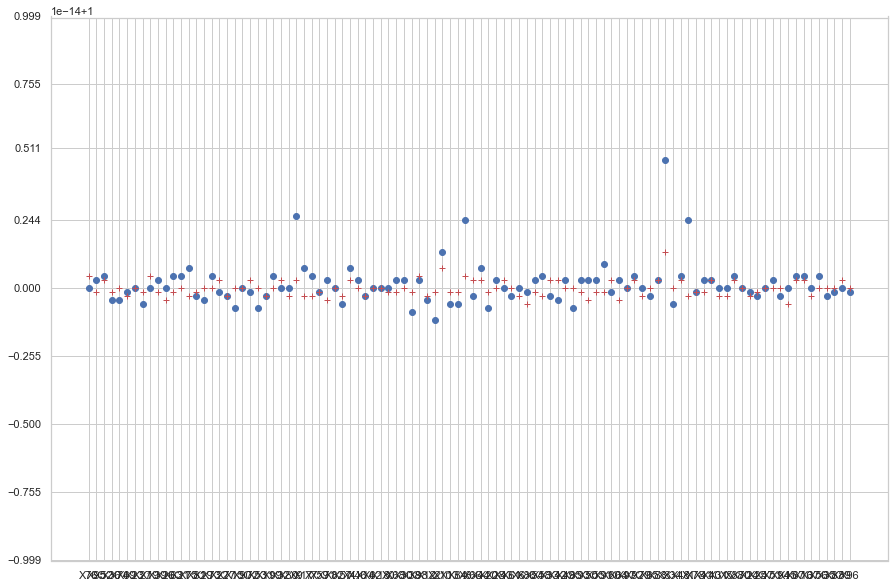

In [13]:
plt.figure(figsize=(15, 10))
plt.ylim((1 - 1e-14, 1 + 1e-14))
# plt.yscale('log')
plot = plt.plot(X_train_fitted.columns, np.std(X_train_fitted),
                'bo', X_test_fitted.columns, np.std(X_test_fitted), 'r+')

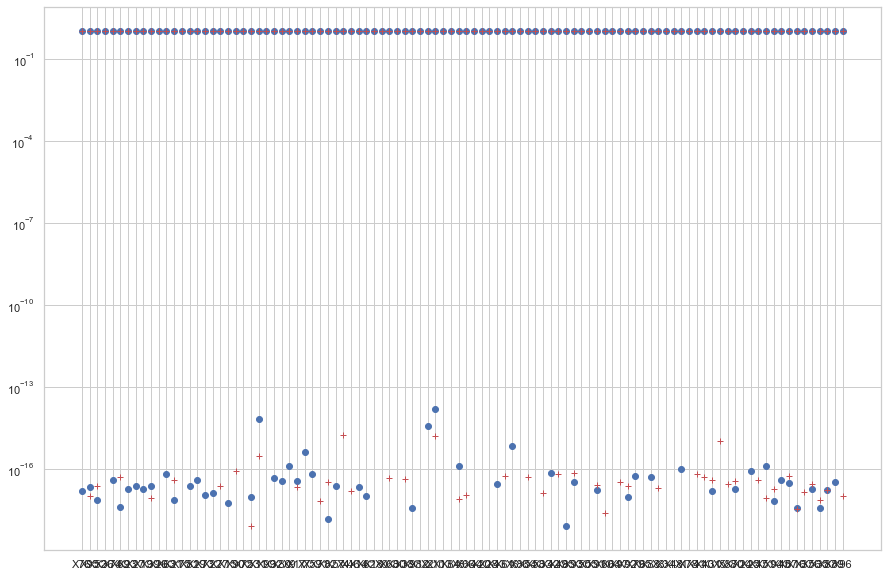

In [14]:
plt.figure(figsize=(15, 10))
#plt.ylim((0 - 5e-14, 0 + 5e-14))
plt.yscale('log')
plot = plt.plot(X_train_fitted.columns, X_train_fitted.mean(), 'bo',
                X_test_fitted.columns, X_test_fitted.mean(), 'r+')
plot = plt.plot(X_train_fitted.columns, X_train_fitted.std(), 'bo',
                X_test_fitted.columns, X_test_fitted.std(), 'r+')

    We note that after standardizing the data, the mean is equal to 0 and the standard deviation equals 1 both in the order of 1e-14.
    
    Standardizing data is very important in the procedure of comparing different covariates that vary in range, amplitude or change rate. 
    In fact, it makes them all based on the same scale in order to have a meaningful covariation when comparing them together. In addition, this improves the LASSO method in particular, since it requires the presence of small, centered covariates in order to yield better answers.
    Actually, when computing the lambda parameters of the LASSO, their amplitudes depend on the amplitude of the variables they are multiplying. 
    Hence, smaller variables improve the minimization that the LASSO method tries to achieve.

In [15]:
df_test = pd.DataFrame()
df_coef = pd.DataFrame()

___
### 2- Functions to compute the determination coefficient and the mean squared error.

In [16]:
def det_coef(y, y_pred):
    """
        params: y is the actual (real measure) output value vector
                y_pred is the prediction output of our model
        return: the determination coefficient of our model if dimensions match 
    """
    if y.shape != y_pred.shape:
        raise ValueError('dimension mismatch')
    y_mean = y.mean()
    # return np.sum(np.power(y_pred - y_mean, 2)) / np.sum(np.power(y - y_mean, 2))
    # another implementation will be :
    return 1 - np.sum(np.power(y - y_pred, 2)) / np.sum(np.power(y - y_mean, 2))


def MSE(y, y_pred):
    """
        params: y is the actual output value vector
                y_pred is the prediction output of our model
        return: the Mean Squarred Error of our model if dimensions match 
    """
    if y.shape != y_pred.shape:
        raise ValueError('dimension mismatch')
    n = y.shape[0]
    return np.sum(np.power(y - y_pred, 2))/n

___
### 3- Fit a linear regression model on the train set.

In [17]:
lin_reg = linear_model.LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_matrix_fitted, y_train)

print('\nDetermination coefficient R^2 = {:.4f}.\n'.format(
    lin_reg.score(X_train_matrix_fitted, y_train)))

y_pred = lin_reg.predict(X_train_matrix_fitted)
# print(y_pred)
print(det_coef(y_train, y_pred))
1 - np.sum(np.power(y_train - y_pred, 2)) / \
    np.sum(np.power(y_train - y_train.mean(), 2)), MSE(y_train, y_pred)


Determination coefficient R^2 = 0.8299.

0.8298513403333554


(0.8298513403333554, 14.515081934234614)

In [18]:
print('\nDetermination coefficient R^2 = {:.4f}.\n'.format(
    lin_reg.score(X_test_matrix_fitted, y_test)))
y_pred = lin_reg.predict(X_test_matrix_fitted)
det_coef(y_test, y_pred), MSE(y_test, y_pred)


Determination coefficient R^2 = 0.5385.



(0.5384852478771162, 37.705300858566474)

In [19]:
lin_reg.intercept_

22.608707124010564

___
### 4- Covariation. SVD decomposition.

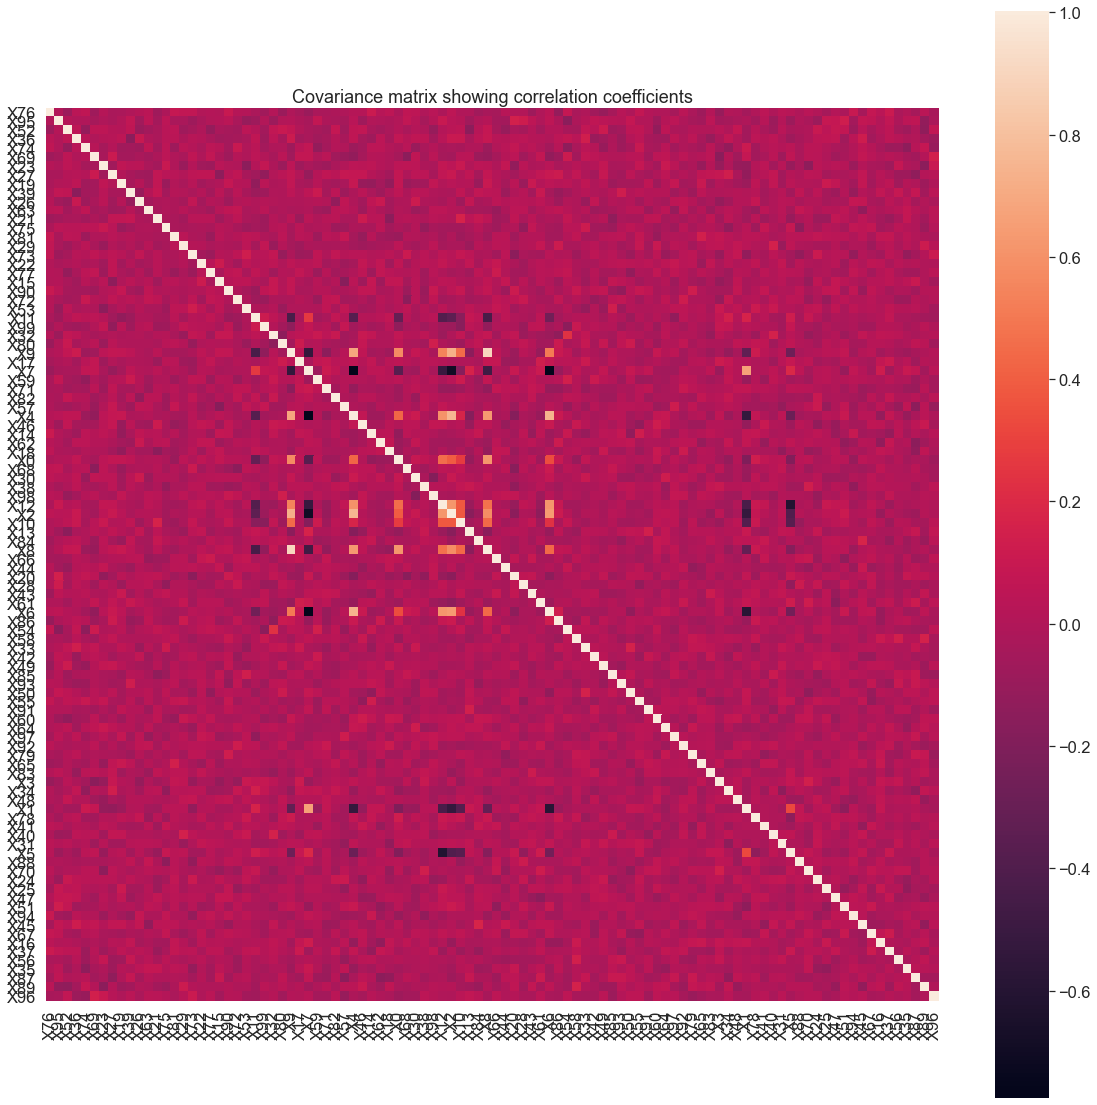

In [20]:
cov_mat = np.cov(X_train_fitted.T)
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=False,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=X_train_fitted.columns,
                 xticklabels=X_train_fitted.columns)
plt.title('Covariance matrix showing correlation coefficients')
plt.show()

In [21]:
colsNb = X_train_fitted.columns
h = np.cov(X_train_fitted.T)
covs = dict()
for i in range(100):
    for j in range(i):
        if h[i][j] > 0.5 and i != j:
            covs[(colsNb[i], colsNb[j])] = h[i][j]
covs

{('X4', 'X9'): 0.6887370714664898,
 ('X0', 'X9'): 0.5729657667808414,
 ('X12', 'X9'): 0.5423968956962054,
 ('X12', 'X4'): 0.601194892688427,
 ('X2', 'X9'): 0.731163013511906,
 ('X2', 'X4'): 0.7577069805119137,
 ('X2', 'X12'): 0.6185337380631449,
 ('X8', 'X9'): 0.9047715376552353,
 ('X8', 'X4'): 0.6303902984649972,
 ('X8', 'X0'): 0.6204535497566127,
 ('X8', 'X2'): 0.5802019505596807,
 ('X6', 'X9'): 0.5094958934638059,
 ('X6', 'X4'): 0.7454911890067448,
 ('X6', 'X12'): 0.6174299797299896,
 ('X6', 'X2'): 0.6368817954842396,
 ('X1', 'X7'): 0.6624575160495887}

    Here is the Singular Vaules Decomposition of the covariations matrix:

In [22]:
cov_mat = np.cov(X_train_fitted.T)
U, s, V = svd(cov_mat)

___
### 5- Primary Component Analysis

In [23]:
S = np.eye(U.shape[0])*s
Us = U.dot(S)
US = Us[:, :2]

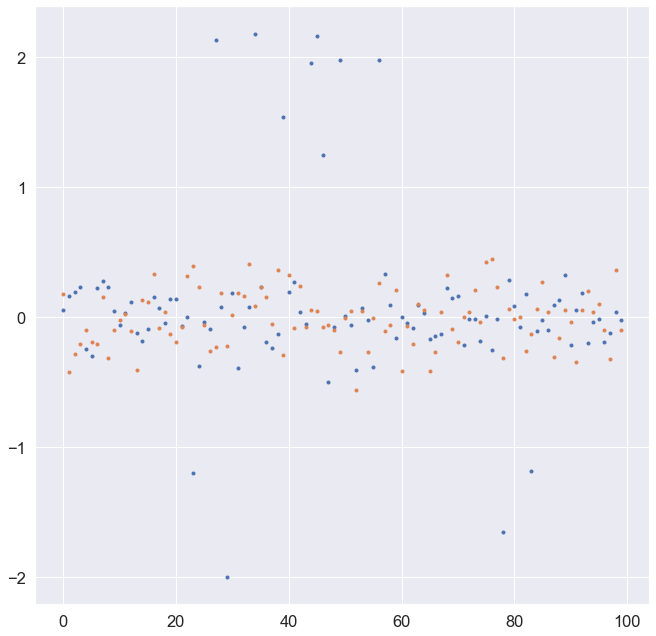

In [24]:
plt.figure(figsize=(11, 11))
plot = plt.plot(US, '.')

In [25]:
PC1 = US[:, 0]
PC2 = US[:, 1]
np.mean(PC1), np.mean(PC2), np.std(PC1), np.std(PC2)

(0.08305489424395124,
 -0.012020246834449008,
 0.6413267496639679,
 0.21619397469484716)

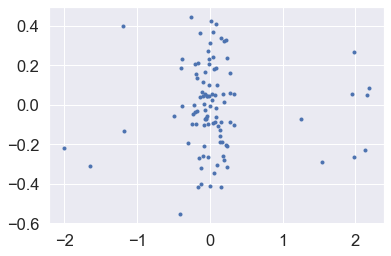

In [26]:
plt.plot(PC1, PC2, '.')

    We notice from the PC1-to-PC2 plot that almost all points go in a straight upwards line, meaning that the eigen value of the PC1 is much greater than that of PC2.

    By taking the 2d projection (covariation) of the selected components matrix, we notice indeed that lambda1 is ten times bigger than lambda2 (diagonal matrix)

In [27]:
US.T.dot(US)

array([[ 4.18198115e+01, -3.10862447e-15],
       [-3.10862447e-15,  4.68843210e+00]])

___
### 6- PCA before OLS

In [28]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(X_train_fitted)
# print(pca.components_.T, pca.explained_variance_)

In [29]:
X_PCA = X_train_fitted.dot(US)
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_PCA, y_train)

LinearRegression()

In [30]:
print('\nDetermination coefficient R^2 = {:.4f}.\n'.format(
    lin_reg.score(X_PCA, y_train)))

y_pred = lin_reg.predict(X_PCA)
det_coef(y_train, y_pred), MSE(y_train, y_pred)


Determination coefficient R^2 = 0.4326.



(0.43259596585947657, 48.40423698606129)

In [31]:
X_PCA_test = X_test_fitted.dot(US)
y_pred = lin_reg.predict(X_PCA_test)
print('\nDetermination coefficient R^2 = {:.4f}.\n'.format(
    lin_reg.score(X_PCA_test, y_test)))
det_coef(y_test, y_pred), MSE(y_test, y_pred)


Determination coefficient R^2 = 0.2137.



(0.21369069126138862, 64.24069635370319)

In [32]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
329,22.6,28.520305
371,50.0,16.609073
219,23.0,23.632533
403,8.3,13.355424
78,21.2,23.344225
...,...,...
49,19.4,27.854698
498,21.2,21.866432
309,20.3,23.100764
124,18.8,21.857791


___
### 7- The loadings Phi

In [33]:
Uss = U.dot(np.sqrt(S))
Phi = np.abs(Us[:, :2])

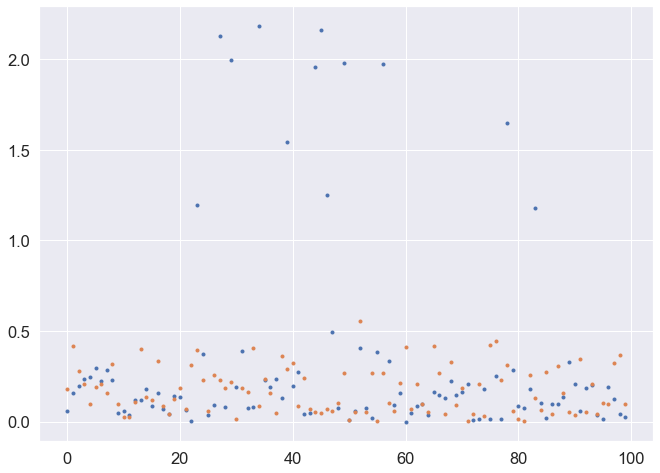

In [34]:
plt.figure(figsize=(11, 8))
plot = plt.plot(Phi, '.')

In [35]:
Phi[:, 0].mean(), Phi[:, 0].std(), Phi[:, 1].mean(), Phi[:, 1].std()

(0.33570664103511355,
 0.552719790180653,
 0.17439994423852512,
 0.12833152565880543)

___
### 8- LASSO

In [36]:
alpha = np.logspace(-3, 1, 30)
lasso_reg = LassoCV(alphas=alpha, n_alphas=30)
lasso_reg.fit(X_train_fitted, y_train)

LassoCV(alphas=array([1.00000000e-03, 1.37382380e-03, 1.88739182e-03, 2.59294380e-03,
       3.56224789e-03, 4.89390092e-03, 6.72335754e-03, 9.23670857e-03,
       1.26896100e-02, 1.74332882e-02, 2.39502662e-02, 3.29034456e-02,
       4.52035366e-02, 6.21016942e-02, 8.53167852e-02, 1.17210230e-01,
       1.61026203e-01, 2.21221629e-01, 3.03919538e-01, 4.17531894e-01,
       5.73615251e-01, 7.88046282e-01, 1.08263673e+00, 1.48735211e+00,
       2.04335972e+00, 2.80721620e+00, 3.85662042e+00, 5.29831691e+00,
       7.27895384e+00, 1.00000000e+01]),
        n_alphas=30)

In [37]:
print(lasso_reg.score(X_train_fitted, y_train))
y_pred = lasso_reg.predict(X_test_fitted)
det_coef(y_test, y_pred), MSE(y_test, y_pred)

0.7835614407800723


(0.5765330130478755, 34.596835904498036)

In [38]:
print("test score =", "{:.4f}".format(lasso_reg.score(X_test_fitted, y_test)))
print("The chosen aplpha by the LassoCrossValid algorithm was", lasso_reg.alpha_)
print("We have", sum(lasso_reg.coef_ != 0), "non-zero prediction coefficients, leaving us with",
      p - sum(lasso_reg.coef_ != 0), "sparse coefficients.")
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

test score = 0.5765
The chosen aplpha by the LassoCrossValid algorithm was 0.2212216291070448
We have 39 non-zero prediction coefficients, leaving us with 61 sparse coefficients.


,Actual,Predicted
329,22.6,27.468684
371,50.0,23.209801
219,23.0,28.565926
403,8.3,13.110860
78,21.2,21.686936
...,...,...
49,19.4,19.471645
498,21.2,20.769177
309,20.3,22.490341
124,18.8,17.298151


In [39]:
lasso_reg.intercept_

22.608707124010603

___
### 9- Ridge

In [40]:
alpha = np.logspace(-1, 2, 30)
ridge_reg = RidgeCV(alphas=alpha)
ridge_reg.fit(X_train_fitted, y_train)

RidgeCV(alphas=array([  0.1       ,   0.1268961 ,   0.1610262 ,   0.20433597,
         0.25929438,   0.32903446,   0.41753189,   0.52983169,
         0.67233575,   0.85316785,   1.08263673,   1.3738238 ,
         1.74332882,   2.21221629,   2.8072162 ,   3.56224789,
         4.52035366,   5.73615251,   7.27895384,   9.23670857,
        11.72102298,  14.87352107,  18.87391822,  23.9502662 ,
        30.39195382,  38.56620421,  48.93900918,  62.10169419,
        78.80462816, 100.        ]))

In [41]:
print("train score =", ridge_reg.score(X_train_fitted, y_train))
y_pred = ridge_reg.predict(X_test_fitted)
det_coef(y_test, y_pred), MSE(y_test, y_pred)

train score = 0.8152206953861048


(0.5355691501139859, 37.94354317473526)

In [42]:
print("test score =", "{:.4f}".format(ridge_reg.score(X_test_fitted, y_test)))
print("The chosen aplpha by the LassoCrossValid algorithm was",
      "{:.4f}".format(ridge_reg.alpha_))
print("We have", sum(ridge_reg.coef_ != 0), "non-zero prediction coefficients, leaving us with",
      (p - sum(ridge_reg.coef_ != 0)), "sparse coefficients.")
print("However, there are", sum(abs(ridge_reg.coef_) < 1e-1),
      "coefficients that are lesser than 0.1")
#pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

test score = 0.5356
The chosen aplpha by the LassoCrossValid algorithm was 48.9390
We have 100 non-zero prediction coefficients, leaving us with 0 sparse coefficients.
However, there are 25 coefficients that are lesser than 0.1


In [43]:
ridge_reg.intercept_

22.608707124010596

___
### 10- Forward Variable Selection FVS

In [44]:
def gram(X):
    n, _ = X.shape
    ones_n = np.ones(n).reshape(1,-1).T
    Xe = np.hstack((ones_n,X))
    return Xe.T.dot(Xe)/n

def sigma_hat(X, y, theta):
    n, p = X.shape
    ones_n = np.ones(n).reshape(1,-1).T
    Xe = np.hstack((ones_n,X))
    y_pred = Xe.dot(theta)
    return np.sqrt( np.sum((y - y_pred) ** 2) / (n - (p+1)))


def s_hat(X):
    inv_gram = np.linalg.inv(gram(X))
    
    return inv_gram[0,0]

def noEffectStat(X, y, theta):
    if X.shape[0] != y.size:
        raise ValueError('dimension mismatch')
    n, _ = X.shape
    s = s_hat(X)
    sigma = sigma_hat(X, y, theta)
    
    return np.abs(np.sqrt(n) * theta[1] / (s * sigma))

In [45]:
X = X_train_matrix_fitted
X_test = X_test_fitted
y = y_train

In [46]:
plotOn = False
selected = list()
candidates = list(range(p))

r = np.array(y)
while len(candidates):
    candidatesStat = dict()
    for i in range(p):
        if i in candidates:
            Xi = (X[:,i].reshape(-1, 1))
            OLSi = linear_model.LinearRegression()
            OLSi.fit(Xi, r)
            theta = np.array([OLSi.intercept_, OLSi.coef_[0]])
            candidatesStat[i] = noEffectStat(Xi, r, theta)
        else: candidatesStat[i] = 0
    if plotOn == True:
        plt.plot(candidatesStat.values(), '-')
        plt.pause(0.1)
    selectedCandidate = max(candidatesStat, key=candidatesStat.get)
    #print("selec. cand=", selectedCandidate)
    candidates.remove(selectedCandidate)
    selected = selected + [selectedCandidate]
    Xi = (X[:,selectedCandidate].reshape(-1, 1))
    OLSi = linear_model.LinearRegression()
    OLSi.fit(Xi, y)
    r = r - OLSi.predict(Xi)

In [47]:
print("The order of the selected variables is:\n", selected)

The order of the selected variables is:
 [44, 46, 29, 56, 34, 45, 27, 49, 78, 39, 23, 83, 47, 55, 52, 31, 24, 57, 89, 7, 76, 5, 79, 68, 4, 41, 3, 37, 35, 66, 6, 90, 8, 2, 92, 96, 82, 30, 74, 71, 40, 14, 93, 16, 36, 70, 65, 97, 19, 88, 59, 1, 69, 67, 62, 12, 53, 13, 38, 20, 28, 33, 80, 26, 10, 58, 86, 84, 63, 51, 21, 81, 32, 0, 87, 15, 48, 11, 43, 85, 18, 9, 42, 17, 64, 94, 99, 60, 54, 91, 22, 77, 98, 25, 61, 73, 75, 95, 50, 72]


In [48]:
hers = [44, 83, 29, 46, 62, 15, 23, 9, 49, 91, 20, 47, 33, 18, 75, 80, 99, 87, 55, 97, 4, 53, 30, 10, 22, 24, 89, 31, 67, 63, 8, 48, 84, 40, 61, 59, 56, 34, 96, 94, 6, 73, 32, 16, 52, 28, 76, 36, 54, 38, 64, 14, 26, 90, 85, 37, 57, 0, 68, 51, 7, 60, 11, 42, 69, 78, 45, 21, 95, 81, 71, 50, 74, 98, 19, 12, 70, 17, 65, 5, 92, 86, 13, 43, 39, 25, 82, 79, 1, 88, 3, 72, 58, 93, 35, 77, 66, 41, 27, 2]
withSameY = [83, 44, 46, 45, 27, 34, 39, 49, 56, 78, 23, 29, 75, 31, 89, 94, 12, 58, 55, 79, 42, 47, 62, 24, 6, 15, 68, 14, 67, 71, 18, 1, 2, 20, 32, 85, 86, 84, 61, 8, 26, 22, 72, 81, 73, 70, 3, 76, 88, 64, 50, 0, 57, 54, 33, 52, 19, 9, 25, 60, 28, 90, 87, 80, 69, 16, 41, 40, 17, 37, 51, 97, 82, 99, 66, 65, 77, 10, 38, 5, 13, 35, 4, 91, 74, 48, 92, 53, 93, 95, 30, 96, 43, 21, 7, 63, 36, 98, 59, 11]

___
### 11- FVS with stopping condition

The p-value is the probability that the test statistic will be as extreme as or more extreme than the value we just got on our sample.

In [49]:
plotOn = False
stop = False
selected = list()
candidates = list(range(p))
firstThreeStats = [0] * 3
firstThreePValueLists = [0] * 3
pValues = [0]*50
count3 = 0
count = 0

r = np.array(y)
pstop = 0.05
while (not stop or count < 50) and count < 50:
    candidatesStat = dict()
    pvaluesiter = dict()
    for i in range(p):
        if i in candidates:
            Xi = (X[:, i].reshape(-1, 1))
            OLSi = linear_model.LinearRegression()
            OLSi.fit(Xi, r)
            theta = np.array([OLSi.intercept_, OLSi.coef_[0]])
            statTest = noEffectStat(Xi, r, theta)
            candidatesStat[i] = statTest
            pvaluesiter[i] = 2 * (1 - norm(0, 1).cdf(statTest))
        else:
            candidatesStat[i] = 0
            pvaluesiter[i] = 1

    if count3 < 3:
        firstThreeStats[count3] = candidatesStat
        firstThreePValueLists[count3] = pvaluesiter
        count3 += 1
        if plotOn:
            plt.plot(candidatesStat.values(), '-')
            plt.plot(pvaluesiter.values(), '-')
            plt.pause(0.1)

    selectedCandidate = max(candidatesStat, key=candidatesStat.get)

    if pvaluesiter[selectedCandidate] > pstop:
        stop = True

    candidates.remove(selectedCandidate)
    # print("removed selected:", selectedCandidate, "\nremains:", candidates)
    if not stop:
        selected = selected + [selectedCandidate]

    Xi = (X[:, selectedCandidate].reshape(-1, 1))
    OLSi = linear_model.LinearRegression()
    OLSi.fit(Xi, y)
    r -= OLSi.predict(Xi)  # equivalent to :  r -=  OLSi.intercept_ + OLSiOLSi.coef_[0] * Xi

    pValues[count] = pvaluesiter[selectedCandidate]
    count += 1
    # print(count)
    # print(np.sum(np.power(r, 2)))        this line is to check the squared module of r

In [56]:
selected, pValues[49]

([44, 46, 29, 56, 34, 45, 27, 49, 78, 39, 23, 83, 47, 55, 52, 31, 24, 57, 89],
 0.3268902956651436)

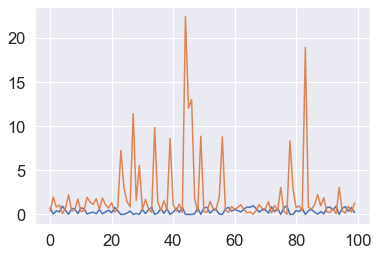

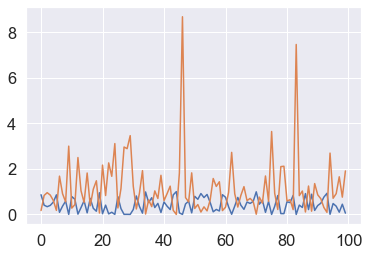

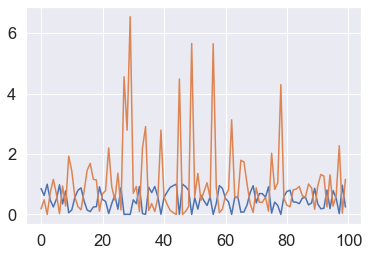

In [57]:
for i in range(3):
    bestpvalue = firstThreePValueLists[i]
    bestTest = firstThreeStats[i]
    plt.plot(bestpvalue.values())
    plt.plot(bestTest.values())
    plt.pause(0.1)

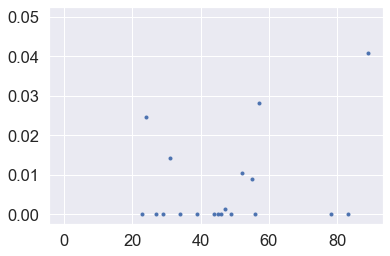

In [65]:
plt.plot(selected, pValues[:19], '.')
plt.plot(0.05, '-')

In [52]:
covariates = X_train_fitted.columns
selectedCovariates = [0]*len(selected)
j=0
for i in selected:
    selectedCovariates[j] = covariates[i]
    j += 1
selected, selectedCovariates

([44, 46, 29, 56, 34, 45, 27, 49, 78, 39, 23, 83, 47, 55, 52, 31, 24, 57, 89],
 ['X12',
  'X10',
  'X7',
  'X6',
  'X4',
  'X2',
  'X9',
  'X8',
  'X1',
  'X0',
  'X11',
  'X5',
  'X13',
  'X61',
  'X20',
  'X71',
  'X99',
  'X86',
  'X51'])

___
### 12- OLS with FVS

In [53]:
X_FVS = X_train_fitted[selectedCovariates]
X_FVS_test = X_test_fitted[selectedCovariates]

OLS_FVS_reg = linear_model.LinearRegression()
OLS_FVS_reg.fit(X_FVS, y_train)

print('\nDetermination coefficient R^2 = {:.4f}.'.format(
    OLS_FVS_reg.score(X_FVS, y_train)))
y_pred = OLS_FVS_reg.predict(X_FVS)
print("my R2 =",det_coef(y_train, y_pred),"\n")

y_pred = OLS_FVS_reg.predict(X_FVS_test)
print(det_coef(y_test, y_pred), OLS_FVS_reg.score(X_FVS_test, y_test))
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


Determination coefficient R^2 = 0.7700.
my R2 = 0.7699697785417892 

0.6243115153646224 0.6243115153646224


,Actual,Predicted
329,22.6,26.392902
371,50.0,24.778377
219,23.0,28.061751
403,8.3,12.894709
78,21.2,22.018322
...,...,...
49,19.4,20.362524
498,21.2,21.937792
309,20.3,24.648787
124,18.8,22.607009


In [54]:
len(OLS_FVS_reg.coef_)

19

___
### 13- Coefficients comparison

___
### 14- Coefficients comparison

___
### 15- Coefficients comparison